In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import scipy

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2023-10-25 14:44:23.546356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 14:44:23.695533: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 14:44:23.700763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-25 14:44:23.700795: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [2]:
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
# raw_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.normalized.txt"


""" Load the raw expression """
df = pd.read_csv(raw_path, index_col=0)
print(f"{df.shape=}")

gene_names = df.index.to_list()

df.head()

df.shape=(19393, 18)


,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
A1BG,12,5,5,9,2,6,7,3,6,5,5,5,4,3,4,5,5,3
A1CF,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,0,0,0
A2M,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,2
A2ML1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 0, 'Time (hr)')

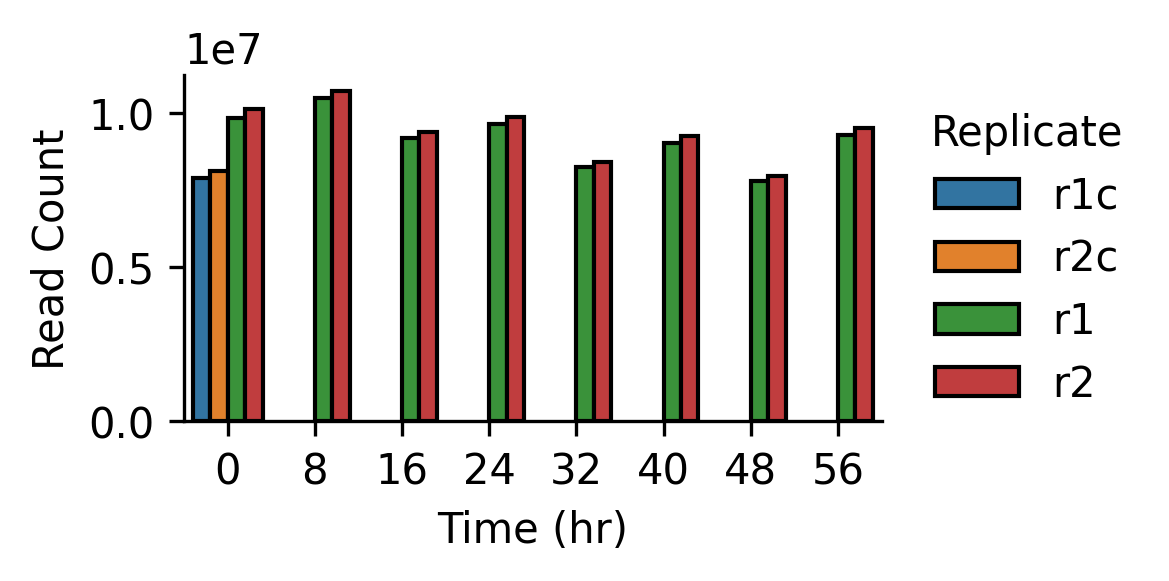

In [7]:
read_sums = df.sum(axis=0)

rdf = pd.DataFrame(read_sums).reset_index(drop=False)
rdf.columns = ['id', 'read_count']
rdf['timepoint'] = rdf['id'].map(nb.tmap)
rdf['time'] = rdf['timepoint'] * 8
rdf['replicate'] = rdf['id'].map(nb.rmap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 1.5

sns.barplot(data=rdf, 
            x='time',
            y='read_count',
            hue='replicate',
            ec='k',
           )

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.4, 1),
                title="Replicate")

plt.ylabel("Read Count")
plt.xlabel("Time (hr)")

In [4]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [8]:
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"
gf = nb.getGeneLengths(raw_path, gene_names)
gf.head()

/tmp/ipykernel_1546515/321717080.py:2: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  gf = nb.getGeneLengths(raw_path, gene_names)


,gene_name,Length
0,A1BG,8315
1,A1CF,86267
2,A2M,48566
3,A2ML1,64381
4,A3GALT2,14333


In [9]:
target = 1e6
tpm = nb.TPM(df, gf, target=target)
cpm = nb.CPM(df, target=target)
print(f"{tpm.shape=} {cpm.shape=}")

tpm.shape=(19393, 18) cpm.shape=(19393, 18)


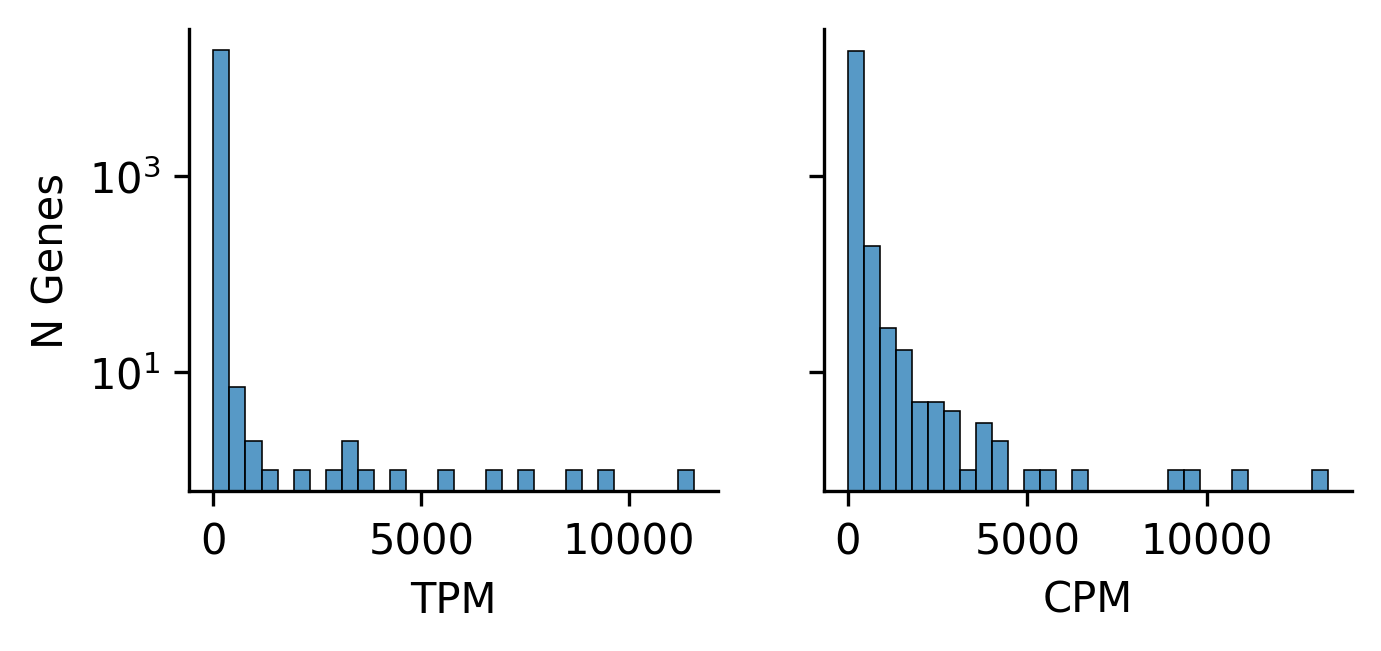

In [10]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2

fig, axs = plt.subplots(1, 2, sharey=True)

tpm_dist = tpm.mean(axis=1)
cpm_dist = cpm.mean(axis=1)


sns.histplot(tpm_dist,
             bins=30,
             ax=axs[0])

axs[0].set_yscale('log')
axs[0].set_xlabel("TPM")
axs[0].set_ylabel("N Genes")

sns.histplot(cpm_dist,
             bins=30,
             ax=axs[1])

axs[1].set_yscale('log')
axs[1].set_xlabel("CPM")
sns.despine()

In [11]:
# threshold = 100
threshold = 200
target = 1e6
# norm = nb.TPM(df, gf, target=target)
norm = nb.CPM(df, target=target)

gene_dist = norm.mean(axis=1)
mask = (gene_dist > threshold)
print(f"N genes with mean normed expression > {threshold} = {mask.sum()}")

high_exp_genes = gene_dist[mask].index 


ddf = df[df.index.isin(high_exp_genes)]
print(f"{ddf.shape=}")

N genes with mean normed expression > 200 = 950
ddf.shape=(950, 18)


Text(0.5, 0, 'Time (hr)')

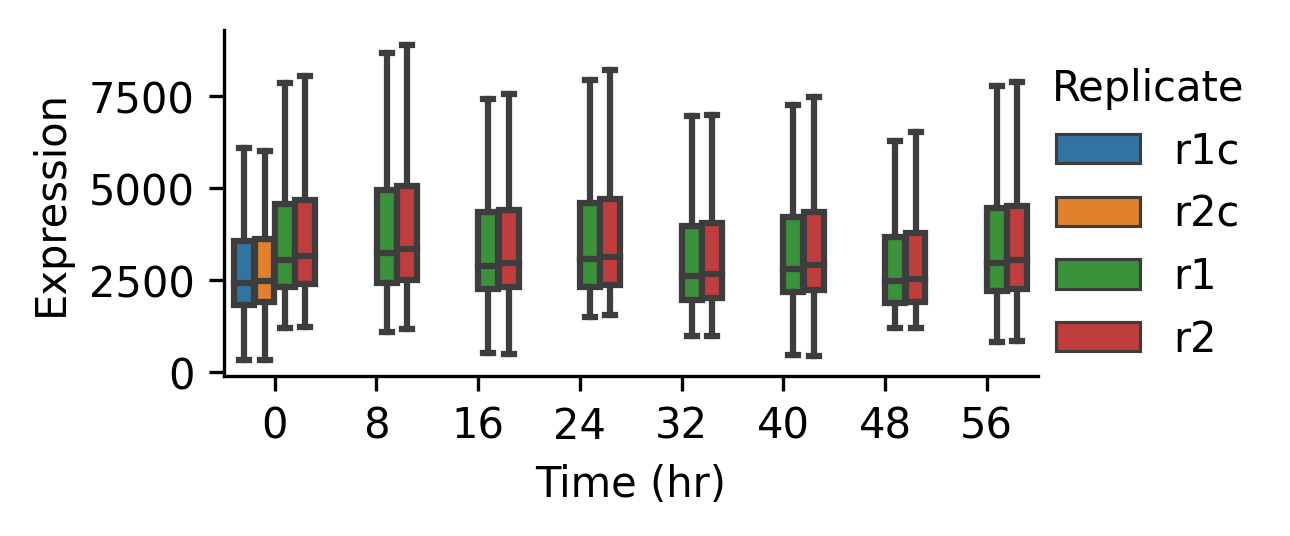

In [12]:
pdf = ddf.copy()
pdf = pdf.reset_index(drop=False)

pdf = pd.melt(pdf, id_vars='geneName')

pdf['timepoint'] = pdf['variable'].map(nb.tmap)
pdf['replicate'] = pdf['variable'].map(nb.rmap)
pdf['hours'] = pdf['timepoint'] * 8

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.5, 1.5

sns.boxplot(data=pdf, 
            x='hours',
            y='value',
            hue='replicate',
            showfliers=False)

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.3, 1),
                title="Replicate")

plt.ylabel("Expression")
plt.xlabel("Time (hr)")

,Threshold,variable,value
0,0,Genes (TPM),16374
1,2,Genes (TPM),4351
2,4,Genes (TPM),2532
3,6,Genes (TPM),1694
4,8,Genes (TPM),1282


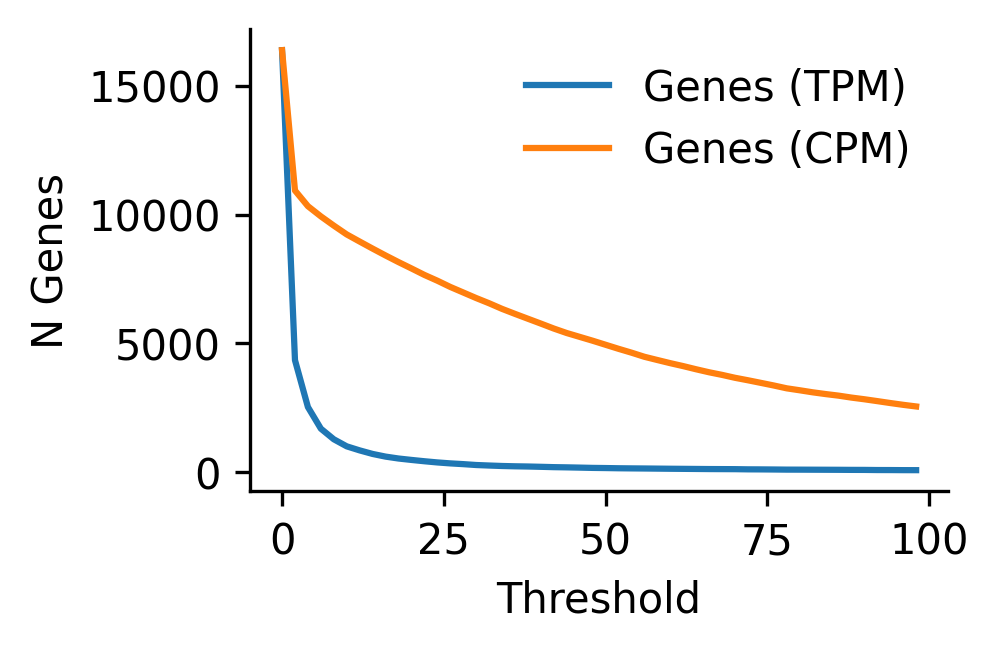

In [13]:
""" The effect of changing thresholds """
target = 1e6
tmp = nb.TPM(df, gf, target=target)
cpm = nb.CPM(df, target=target)

tpm_dist = tmp.mean(axis=1)
cpm_dist = cpm.mean(axis=1)

res = []

for t in np.arange(0, 100, 2):
    tpm_kept = (tpm_dist > t).sum()
    cpm_kept = (cpm_dist > t).sum()

    row = {
        'Threshold' : t,
        'Genes (TPM)' : tpm_kept,
        'Genes (CPM)' : cpm_kept,
    }
    res.append(row)
    
res = pd.DataFrame(res)
res = pd.melt(res, id_vars='Threshold')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.lineplot(data=res, 
             x='Threshold',
             y='value',
             hue='variable')

sns.despine()
sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="")

plt.ylabel("N Genes")
plt.xlabel("Threshold")

res.head()

In [ ]:
# break

In [14]:
# build fold-change dataframe

def getFCFrame(df, cols):
    """A function to return a new dataframe with 
    foldchanges over the initial. Expects cols to be time-ordered
    and that cols[0] is the initial condition """
    df2 = df[cols].copy()
    x0 = cols[0] # initial condition
    for c in cols[1:]:
        df2[c] = (df2[c] + 1) /  (df2[x0].mean() + 1)
    return df2[cols[1:]].copy()


def data2DMD(df):
    """A function to make DMD suitable data from the 2015 data"""
    a = [x for x in df.columns if "a" in x]
    b = [x for x in df.columns if "b" in x]

    dfa = getFCFrame(df, a)
    dfb = getFCFrame(df, b)

    scaler = StandardScaler()

    dfa = scaler.fit_transform(dfa)
    dfb = scaler.fit_transform(dfb)
    
    dmd_data = np.asarray([dfa, dfb])
    dmd_data = np.swapaxes(dmd_data, 0, 2)
    dmd_data = np.swapaxes(dmd_data, 0, 1)

    return dmd_data


def getMuData(df):
    """A function to get the mean expression of each replicate at
    each time point """
    mu_data = df.copy()
    mu_data = mu_data.T

    mu_data = mu_data.reset_index(drop=False)
    mu_data['time'] = mu_data['index'].apply(lambda x: x.replace("a", "").replace("b", "").replace('S', ''))
    mu_data['time'] = mu_data['time'].astype(int)
    mu_data = mu_data.drop(columns=['index'])
    mu_data = mu_data.groupby('time').mean().reset_index(drop=False)
    mu_data = mu_data.sort_values(by='time')
    mu_data = mu_data.set_index('time')
    return mu_data
    

dmd_data = data2DMD(ddf)
print(f"{dmd_data.shape=}")

mu_data = getMuData(ddf)
mu_data.shape

mu_data.head()

dmd_data.shape=(950, 8, 2)


geneName,AARS1,ACADM,ACIN1,ACLY,ACSL4,ACTB,ACTG1,ACTN4,ACTR2,ACTR3,...,ZFP36L1,ZMAT3,ZMIZ1,ZNF106,ZNF146,ZNF207,ZNF217,ZNF292,ZNF740,ZRANB2
time,,,,,,,,,,,,,,,,,,,,,
1,1922.5,2328.5,2256.0,2152.0,1596.5,84100.5,36757.5,2237.0,7235.5,5038.5,...,2119.5,1786.0,2249.5,1612.0,1646.5,2947.0,3443.5,2400.0,2695.0,2377.5
2,2971.5,3186.5,2911.0,2927.5,1932.5,117844.0,49446.5,2741.0,9710.0,7239.0,...,2127.5,1885.5,2527.0,1979.0,2059.5,3177.0,3706.5,2598.0,3052.0,2156.5
3,2572.5,3489.5,2910.0,2863.5,2444.5,125538.5,57956.5,2297.0,11822.5,8398.0,...,2212.5,1720.5,2434.0,2177.5,2463.0,3461.5,4692.0,3127.0,3536.5,3134.0
4,2226.0,3372.5,2395.5,2520.0,2392.5,90514.5,43105.5,2231.5,10156.5,6821.0,...,2105.0,2214.5,1993.5,2011.5,2380.5,4342.5,3797.5,3277.0,3027.0,3828.0
5,3067.5,3446.0,2802.0,2838.5,2112.0,105207.5,50939.0,2310.5,10274.5,7052.5,...,1780.5,2135.5,2279.5,2033.5,2199.5,3862.0,3536.5,3049.0,2982.0,2459.5


In [ ]:
break

In [18]:
""" study the rank """

n_rank = ddf.shape[1] - 1
max_rank = ddf.shape[1] - 1
sample_size = ddf.shape[0] # all genes

def sample_genes(gene_names, sample_size=100):
    """A function to sample genes """
    genes  = np.random.choice(gene_names, sample_size, replace=False)
    r_ind = np.array([gene_names.index(x) for x in genes])
    genes  = pd.DataFrame({'gene_name' : genes,
                           'index' : r_ind})
    return genes 

# sample the same genes over multiple rank estimations
genes = sample_genes(gene_names, sample_size=sample_size)
exact = False 

res = []

for rank in np.linspace(2, max_rank, n_rank).astype(int):
    print(f"Working {rank=}")
    dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
    X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
    
    t_res = hasnain_DMD.sample_correlations(genes, dmd_data, X_pred)
    t_res['rank'] = rank

    res.append(t_res)

res = pd.concat(res)
print(res.head())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

sns.boxplot(data=res, 
            x='rank',
            y='corr',
            color='lightgrey',
            showfliers=False,
            whiskerprops={"color": "k", "lw" : 1},
            capprops={"color": "k", "lw" : 1},
            boxprops={"facecolor": 'lightgrey', "edgecolor": "k", "lw" : 1},
            medianprops={"color": "k", "lw" : 1},
            )

plt.ylabel("Correlation (pred vs. actual)")
plt.xlabel("DMD Rank")
sns.despine()

Working rank=2
Working rank=2
Working rank=3
Working rank=4
Working rank=5
Working rank=6
Working rank=7
Working rank=8
Working rank=9
Working rank=10
Working rank=11
Working rank=12
Working rank=13
Working rank=14
Working rank=15


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 14)

In [ ]:
break

In [ ]:
rank = 10 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD
dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
print(dmd_res.keys())

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

sval = dmd_res['SVD'][1]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(sval, lw=0.75, c='k', marker=".")
plt.title(r"Singluar Values of $\mathbf{X}_p$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{sval.max()=:.4f} {sval.min()=:.4f}")

sns.despine()

In [ ]:
""" Plot DMD eigenvalues  """
t = np.linspace(0, np.pi*2, 100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

L = dmd_res['L']

# make the unit circle
plt.plot(np.cos(t), 
         np.sin(t), 
         linewidth=1, 
         c='k',
         zorder=1)

pdf = pd.DataFrame({'real' : np.real(L),
                    'imaginary' : np.imag(L)})

print(f"{pdf.shape=}")
pdf['mode'] = list(range(1, len(pdf)+1))

# plot the eigenvalues
sns.scatterplot(data=pdf,
                x='real', 
                y='imaginary',
                s=100,
                marker=".",
                # legend=False,
                hue='mode',
                # c='r',
                ec='k',
                palette='tab20',
                zorder=3)

# add the axis
plt.axvline(x=0, ls=":", c='grey', zorder=0)
plt.axhline(y=0, ls=":", c='grey', zorder=0)

plt.axis('equal')
plt.title("DMD Eigenvalues")
plt.xlabel(r'$\mathregular{Re(\lambda)}$')
plt.ylabel(r'$\mathregular{Im(\lambda)}$')

sns.move_legend(plt.gca(), 
                title='Mode',
                frameon=False, 
                loc='upper right',
                bbox_to_anchor=(1.4, 1.1))

sns.despine()

In [ ]:
""" Plot DMD eigenvalues  """

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

L = np.real(dmd_res['L'])

plt.plot(np.flip(sorted(L)), marker=".", c='k', lw=0.75, zorder=2)
plt.axhline(y=0, zorder=1, lw=0.75)
plt.ylabel(r'$\mathregular{Re(\lambda)}$')
plt.xlabel("Eigenvalue")
plt.title(r"Eigenvalues of $\mathbf{A}$")
sns.despine()

In [ ]:
# ut.makeColorbar('RdYlGn', 0.2, 2.5, 'Expression', 'vertical', ['Low', 'High'])

In [ ]:
# break

In [ ]:
# """
# visualize top genes for each mode
# """

# top_n = 50

# phi = np.real(dmd_res['Phi'])
# phi = pd.DataFrame(phi, index=high_exp_genes)
# print(f"{phi.shape=}")
# phi = phi.rank(ascending=False)

# top_genes = []

# for c in phi.columns:
#     # phi = phi.sort_values(by=c, ascending=True)
#     # print(phi.head())
#     top_genes += phi[phi[c] <= top_n][c].index.to_list()
#     # print(f"----- Mode {c+1} -----")
#     # print(np.random.choice(top_genes, 10, replace=False))
#     # break
    
# pdf = mu_data[top_genes].T
# print(f"{pdf.shape=}")
# pdf = pdf.drop(columns=1)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 6

# sns.heatmap(data=np.sqrt(pdf),
#             cbar=False,
#             cmap='viridis',
#             zorder=0)

# # plt.yticks([], [])
# ax = plt.gca()

# ypoints = np.linspace(0, pdf.shape[0] * top_n, pdf.shape[0]).astype(int)
# for y in ypoints[1:]:
#     plt.axhline(y=y, zorder=2, c='k', lw=1)

# yticks =  np.linspace(0, pdf.shape[0], 9  )
# yticks = yticks + (top_n / 2)
# yticklabels = [f"Mode {c+1}" for c in phi.columns]
# print(yticks)
# print(yticklabels)

# _ = plt.yticks(yticks[:-1],yticklabels)
# plt.ylabel("")

# xtickLabels = np.array(range(0, 8)) * 8 # hours between time points
# ax.set_xticklabels(xtickLabels)
# plt.xlabel("Time (hr)")

In [ ]:
# ut.makeColorbar('viridis', 0.2, 2.5, 'Expression', 'vertical', ['Low', 'High'])

# Explore the top genes for each mode

In [ ]:
top_n = 200
alpha = 0.01

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=high_exp_genes)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)


# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

edf = []


for c in phi.columns:
    genes = phi[phi[c] <= top_n][c].index.to_list()
    
    enrich = gget.enrichr(genes, database=db)
    enrich = enrich[['path_name', 'adj_p_val', 'overlapping_genes']]
    enrich = enrich[enrich['adj_p_val'] <= alpha]
    enrich['mode'] = c + 1
    pd.set_option('display.max_colwidth', 100)

    print(f"======== Mode {c+1} ========")
    print(enrich[['path_name', 'adj_p_val']].head(10))

    edf.append(enrich)
    print()
    time.sleep(1)

    
    # break

edf = pd.concat(edf)
edf.to_csv("mode_genes.csv")
print('done')

In [ ]:
# top_n = 5
# modes = [0]

# X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
# print(f"Correlation: {cd:.4f}")

# phi = np.real(dmd_res['Phi'])
# phi = pd.DataFrame(phi, index=high_exp_genes)
# print(f"{phi.shape=}")
# phi = phi.rank(ascending=False)

# top_genes = []

# for c in modes:
#     top_genes += phi[phi[c] <= top_n][c].index.to_list()

# r_ind = np.array([high_exp_genes.index(x) for x in top_genes])

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 1.3*top_n

# fig, axs = plt.subplots(top_n, 1, sharex=True)


# for i, g in enumerate(r_ind):

#     g_name = top_genes[i]
#     actual = dmd_data[g]


#     actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2'])
#     actual['time'] = list(range(0, len(actual)))
#     actual = pd.melt(actual, id_vars='time')

#     sns.lineplot(data=actual, 
#                  x='time',
#                  y='value',
#                  hue='variable',
#                  lw=1,
#                  ax=axs[i],
#                  palette='Blues')

#     act_mean = np.mean(dmd_data[g], axis=1).ravel()
#     pred_mean = np.mean(X_pred[g], axis=1).ravel()

#     corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

#     axs[i].plot(pred_mean, color='r', label='Predicted')
#     axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
#     axs[i].legend()

#     if i == 0:

#         sns.move_legend(axs[i],
#                         loc='upper right',
#                         title='',
#                         bbox_to_anchor=(1.6, 1),
#                         frameon=False,)
#     else:
#         axs[i].legend().remove()
    
#     axs[i].set_ylabel("FC")
#     # xticks = np.linspace(0, 15, 4)
#     # xtickLabels = np.linspace(0, 64, 4).astype(int)
#     axs[i].set_xticks([])
#     axs[i].set_xticklabels([])
#     axs[i].set_xlabel("Time (hr)")
#     axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

# plt.tight_layout()
# sns.despine()

# Study the Rank

In [ ]:
""" study the rank """

n_rank = rank
max_rank = rank
sample_size = ddf.shape[0] # all genes

def sample_genes(gene_names, sample_size=100):
    """A function to sample genes """
    genes  = np.random.choice(gene_names, sample_size, replace=False)
    r_ind = np.array([gene_names.index(x) for x in genes])
    genes  = pd.DataFrame({'gene_name' : genes,
                           'index' : r_ind})
    return genes 

# sample the same genes over multiple rank estimations
genes = sample_genes(gene_names, sample_size=sample_size)
exact = False 

res = []

for rank in np.linspace(2, max_rank, n_rank).astype(int):
    print(f"Working {rank=}")
    dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
    X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
    
    t_res = hasnain_DMD.sample_correlations(genes, dmd_data, X_pred)
    t_res['rank'] = rank

    res.append(t_res)

res = pd.concat(res)
print(res.head())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

sns.boxplot(data=res, 
            x='rank',
            y='corr',
            color='lightgrey',
            showfliers=False,
            whiskerprops={"color": "k", "lw" : 1},
            capprops={"color": "k", "lw" : 1},
            boxprops={"facecolor": 'lightgrey', "edgecolor": "k", "lw" : 1},
            medianprops={"color": "k", "lw" : 1},
            )

plt.ylabel("Correlation (pred vs. actual)")
plt.xlabel("DMD Rank")
sns.despine()

In [ ]:
break

In [ ]:
def gram_matrix(A, x0, nT=50, reduced=True, projection_matrix=np.array([])):
    '''
    A: matrix representation of the Koopman operator
    x0: initial conditions from measurements
    nT: number of timepoints over which to compute the Gram matrix
    reduced: if True, will compute reduced G from reduced data and KO and will also return full G after inverse projection
    projection_matrix: the matrix used to project data and KO to low-dimensional space (first r eigenvectors of Data.T @ Data)
    Both A and x0 can be either the full dimensional data and KO or they can be the DMD projected data and KO
    If projected, then return both the projected G and the full G after inverting the projection
    If not projected, then compute full G (can be slow, especially if the data dimension exceeds a couple thousand)
    Furthermore, for sensor placement we need to compute the eigendecomposition of G, so having the reduced G is handy   
    '''
    # generate artificial initial conditions for robust optimization 
    # get the min and max of each gene's initial value
    x0min = np.min(x0, axis=1)
    x0max = np.max(x0, axis=1)
    # form a set of new initial conditions distributed uniformly from x0min to x0max
    numICs = x0.shape[0]
    x0uni = np.zeros((len(x0min),numICs))
    x0uni[:,0:x0.shape[1]] = deepcopy(x0)
    for ii in range(x0.shape[1], x0uni.shape[1]):
        x0tmp = np.random.uniform(x0min,x0max)
        x0uni[:,ii] = x0tmp

    G = np.zeros_like(A)
    for ii in range(nT):
        print(f"{ii}...")
        A_pow = np.linalg.matrix_power(A,ii)
        G += np.matmul( np.matmul(A_pow, x0uni), np.matmul(x0uni.T, A_pow.T) ) 
    # right eigenvectors of G (columns of V) are rows of the gene sampling matrix (or vector if just one eigvec kept)

    if reduced: 
        Gfull = np.matmul(np.matmul(projection_matrix, G), projection_matrix.T)
        return G, Gfull
    else: 
        return G # this is the full G, computed directly from full KO and data


A = dmd_res['Atilde']
u = dmd_res['u_r']
data_embedded = dmd_res['data_embedded']
nT = 7
G, Gfull = gram_matrix(A, data_embedded[:,0,:], nT=nT, reduced=True, projection_matrix=u)
print(f"{G.shape=} {Gfull.shape=}")

In [ ]:
# break

In [ ]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(Gfull)
print(f"{D.shape=}{ V.shape=}")

In [ ]:
n_val = 10
evals = D[:n_val]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(evals, lw=0.75, c='k', marker=".")
plt.title(r"Eigenvalues of $\mathbf{G}$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{evals.max()=:.4f} {evals.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

In [ ]:
obs = pd.DataFrame({'gene' : high_exp_genes,
                    'ev1' : V[:,0],
                    'weight' : np.real(V[:,0])})

obs['rank'] = obs['weight'].rank()
obs = obs.sort_values(by='rank', ascending=False)

obs.head(10)

In [ ]:
# obs['gene'].head(10).to_list()

In [ ]:
# obs.tail(20)

In [ ]:
# fpath = "2015.obs.ranking.csv"
# obs.to_csv(fpath, index=False)

In [ ]:
n_gene = 200
# genes = obs['gene'].head(n_gene).to_list()
genes = obs['gene'].tail(n_gene).to_list()

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(genes, database=db)
pd.set_option('display.max_colwidth', 100)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(20)

In [ ]:
# alpha = 0.01
# edf = enrich[['path_name', 'adj_p_val', 'overlapping_genes']]
# edf = edf[edf['adj_p_val'] <= alpha]

# fapth = "top_200_observable_GSEA.csv"
# edf.to_csv(fapth, index=False)

In [ ]:
kid = "hsa04110"
pway_genes = ut.parseKEGG(kid)
len(pway_genes)

In [ ]:
top = 500
observables = obs['gene'].head(top).to_list()
hits = [x for x in observables if x in pway_genes]
print(len(hits))

# State estimation

In [ ]:
## state estimation
rep = 0
t = 7 # not including the initial condition
x0 = dmd_data[:, 0, rep]
A = dmd_res['A']

Kt = []

for i in np.arange(0, t):
    print(f"Computing A^{i}...")
    At = np.linalg.matrix_power(A, i)
    Kt.append(At)

print('done')

In [ ]:
def select_sensors(V, n_sensors=10):
    q1 = np.real(V[:,0])
    ind = np.argpartition(q1, -n_sensors)[-n_sensors:] # leading eigenvector
    w = np.zeros(q1.shape)
    w[ind] = q1[ind]
    return w
    

def reconstruct_x0(data,nT,A,C):
    '''
    The matrix C should be of shape (pxn) if the data are shape (nxm) for p measured genes, n total genes, and m samples
    If p << n, leave only entries of C that correspond to the p genes as nonzero.
    '''
    # generate outputs at nT timepoints, check rank of O_T, and estimate IC
    O_T = np.zeros((len(C)*nT,C.shape[1])) # O_T has dim p*nT x n
    for ii in range(O_T.shape[0]): # observability matrix
        O_T[ii] = C @ np.linalg.matrix_power(A,ii)    

    # use the learned dynamics and sampling to generate output over time
    y = np.zeros((len(C),nT)) 
    for ii in range(nT):
        y[:,ii] = C @ np.linalg.matrix_power(A,ii) @ data[:,0]

    # estimate of x0 
    x0_est = np.linalg.pinv(O_T) @ y.T

    return x0_est


n_sensors = 10
C = select_sensors(V, n_sensors=10)
C = np.expand_dims(C, axis=0)
nT = 3
data = dmd_data[:, :, 0]
x0 = dmd_data[:, 0, 0]
A = dmd_res['A']

z0 = reconstruct_x0(data, nT, A, C)

l2 = np.linalg.norm(z0 - x0)
score, pval = scipy.stats.pearsonr(np.squeeze(z0), x0)
print(f"{n_sensors=} {nT=} {l2=} {score=} {pval=}")

n_sensors=10 nT=2 l2=26523.348000151007 score=0.40856815914052497 pval=0.0

In [ ]:
""" Build the observed data matrix: need to only index the sensors, or all?"""

def estimate_z0(n_sensors, nT, Kt, data, V):
    """A function to estimate the initial condition given:
        : n_sensors (int) the number of top sensors to select, given the principal eigenvector of the Gram matrix
        : nT (int): number of timepoints for which to construct the estimation. Bounded the len(Kt).
        : Kt (list of gene x gene array): The precomputed exponentiation of the learned dynamics from DMD 
        : data (gene x time): the original data for a single replicate
        : V : the eigenvectors of the Gram matrix (columns are eigenvectors)
    """
    # get the gene sampling wieghts and select sensors
    q1 = np.real(V[:,0])
    ind = np.argpartition(q1, -n_sensors)[-n_sensors:] # leading eigenvector
    w = np.zeros(q1.shape)
    w[ind] = q1[ind]

    # compute the measurements and the esitmated dynamics, given the 
    # selected sensors
    # outputs
    yt = []
    O = []
    for i in np.arange(0, nT):
        print(i)
        yt.append( np.dot(w, data[:, i]))
    
        if i == 0:
            O.append(w)
        else:
            wKt = np.dot(w, Kt[i])
            O.append(wKt)

    yt = np.asarray(yt)
    O = np.asarray(O)
    print(f"{yt.shape=} {O.shape=}")
    z0 = np.dot(np.linalg.pinv(O), yt)
    return z0
    
n_sensors = 10
nT = 10
data = dmd_data[:, :, 1]
z0 = estimate_z0(n_sensors, nT, Kt, data, V)

np.linalg.norm(z0 - x0)

In [ ]:
nT = 4
data = dmd_data[:, :, 0]

res = []

for n_sensors in np.arange(10, 1000, step=100):
    z0 = estimate_z0(n_sensors, nT, Kt, data, V)
    score, pval = scipy.stats.pearsonr(z0, x0)
    l2 = np.linalg.norm((z0-x0))
    row = {
        'n_sensors' : n_sensors,
        'corr' : score,
        'pval' : pval,
        'norm' : l2,
    }
    res.append(row)
    
res = pd.DataFrame(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.lineplot(data=res, 
              x='n_sensors',
              y='norm')

plt.ylabel(r"$||\hat{x}_0 - x_0||_2$")
plt.xlabel("Number of Sensors")
plt.show()

sns.lineplot(data=res, 
              x='n_sensors',
              y='corr')

plt.ylabel(r"corr$(\hat{x}_0, x_0)$")
plt.xlabel("Number of Sensors")
plt.show()

res.head()

In [ ]:
break

In [ ]:
# get the sensors
w = np.real(V[:,0])
ind = np.argpartition(w, -n_sensors)[-n_sensors:]
w_bin = np.zeros(w.shape)
w_bin[ind] = w[ind]

print(np.asarray(gene_names)[ind])

yt_true = dmd_data[:, t-1, rep] # t-1 for index offset
A = dmd_res['A']

print(f"{A.shape=} {x0.shape=} {w.shape=} {yt_true.shape=}")

At = np.linalg.matrix_power(A, t)
print(f"{At.shape=}")

In [ ]:
# get the sensors
n_sensors = 100
w = np.real(V[:,0:n_sensors])
C = np.zeros(w.shape)

row_ind = np.argpartition(w[:, 0], -n_sensors)[-n_sensors:] # leading eigenvector
col_ind = np.arange(0, n_sensors)

C[row_ind, col_ind] = 1
print(f"{C.shape=} {C.sum()=}")

yt_pred = np.dot(C.T, np.dot(At, x0))
print(f"{yt_pred.shape=} {yt_true.shape=} {yt_true[row_ind].shape=}")

# print()
# print(yt_true[ind])
# print()
# print(yt_pred)
# print()

np.corrcoef(yt_true[row_ind], yt_pred)


In [ ]:
np.corrcoef(yt_true[ind], test)

In [ ]:
test